In [1]:
# Import required libraries
import sys
import os

# Add src directory to path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Import custom utilities
from utils import (
    execute_query,
    get_task_statistics,
    get_assignee_workload,
    get_project_metrics,
    get_overdue_tasks,
    get_tasks_by_bottleneck
)

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

%matplotlib inline

print("✅ Libraries imported successfully")

Database path: c:/Users/anshu/Desktop/Projects/Avish_flow/data/workflow_data.db
✅ Libraries imported successfully


## 1. Data Loading & Overview

In [2]:
# Load all tasks from database
query = "SELECT * FROM tasks"
df = execute_query(query)

# Convert date columns
date_cols = ['created_date', 'start_date', 'end_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print(f"Dataset Shape: {df.shape}")
print(f"Total Tasks: {len(df):,}")
print(f"Date Range: {df['created_date'].min()} to {df['created_date'].max()}")
print(f"\nColumn Data Types:")
print(df.dtypes)

Dataset Shape: (1000, 15)
Total Tasks: 1,000
Date Range: 2025-10-07 00:00:00 to 2025-12-25 00:00:00

Column Data Types:
task_id                     object
task_name                   object
assignee                    object
status                      object
created_date        datetime64[ns]
start_date          datetime64[ns]
end_date            datetime64[ns]
priority                    object
comments                    object
project                     object
planned_duration            object
actual_duration            float64
is_delayed                   int64
is_overdue                   int64
bottleneck_type             object
dtype: object


In [3]:
# Display sample records
print("\n📋 Sample Tasks:")
df.head(10)


📋 Sample Tasks:


,task_id,task_name,assignee,status,created_date,start_date,end_date,priority,comments,project,planned_duration,actual_duration,is_delayed,is_overdue,bottleneck_type
0,TASK-0001,Deploy Whiteboard One-To-One Web-Readiness,John,Done,2025-12-17,2025-12-20,2025-12-26,Medium,Each cause bill scientist nation opportunity all.,Website Revamp,None,6.0,0,0,None
1,TASK-0002,Build Evolve Killer E-Services,John,In_Review,2025-11-25,2025-11-28,2025-12-01,Low,Ago current practice nation determine operatio...,Internal Ops,None,3.0,0,0,None
2,TASK-0003,Write Facilitate Efficient Eyeballs,Carlos,To_Do,2025-10-27,2025-10-28,2025-11-01,Low,None,Internal Ops,None,4.0,0,0,None
3,TASK-0004,Deploy Engineer Cross-Platform Platforms,Lina,In_Progress,2025-10-16,2025-10-16,2025-10-23,Low,Benefit suggest page southern role movie win her.,Marketing Campaign,None,7.0,0,0,None
4,TASK-0005,Write Engage Distributed Functionalities,John,Done,2025-12-06,2025-12-08,2025-12-15,High,Officer relate animal direction eye bag do big.,Marketing Campaign,None,7.0,0,0,None
5,TASK-0006,Review Empower Ubiquitous Functionalities,Lina,Done,2025-11-11,2025-11-12,2025-11-15,Medium,Have decide environment view possible particip...,Website Revamp,None,3.0,0,0,None
6,TASK-0007,Deploy Leverage Interactive Communities,Carlos,In_Progress,2025-11-20,2025-11-23,2025-11-27,High,Establish understand read detail food shoulder...,Marketing Campaign,None,4.0,0,0,None
7,TASK-0008,Deploy Exploit Turn-Key Interfaces,Ahmed,Done,2025-11-01,2025-11-04,2025-11-10,Medium,Decision wall then fire pretty.,App Launch,None,6.0,0,0,None
8,TASK-0009,Deploy Strategize Ubiquitous Eyeballs,John,In_Progress,2025-11-01,2025-11-04,2025-11-11,Medium,None,App Launch,None,7.0,0,0,None
9,TASK-0010,Design Enable Interactive Schemas,Carlos,To_Do,2025-11-28,2025-12-02,2025-12-08,High,Section investment on gun young catch management.,Marketing Campaign,None,6.0,0,0,Resource_Availability


In [4]:
# Data quality check
print("🔍 Data Quality Report:\n")
print("Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
quality_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)

print(quality_df[quality_df['Missing Count'] > 0])

print("\n✅ Data loaded successfully!")

🔍 Data Quality Report:

Missing Values:
                  Missing Count  Missing %
planned_duration           1000      100.0
bottleneck_type             631       63.1
comments                    210       21.0
actual_duration              47        4.7
end_date                     47        4.7

✅ Data loaded successfully!


## 2. Task Distribution Analysis

In [5]:
# Overall task statistics
stats = get_task_statistics()
print("📊 Overall Task Statistics:\n")
print(stats.T)

📊 Overall Task Statistics:

                          0
total_tasks      1000.00000
completed_tasks   351.00000
blocked_tasks     114.00000
delayed_tasks      81.00000
avg_duration        6.72298
total_assignees     8.00000
total_projects      4.00000


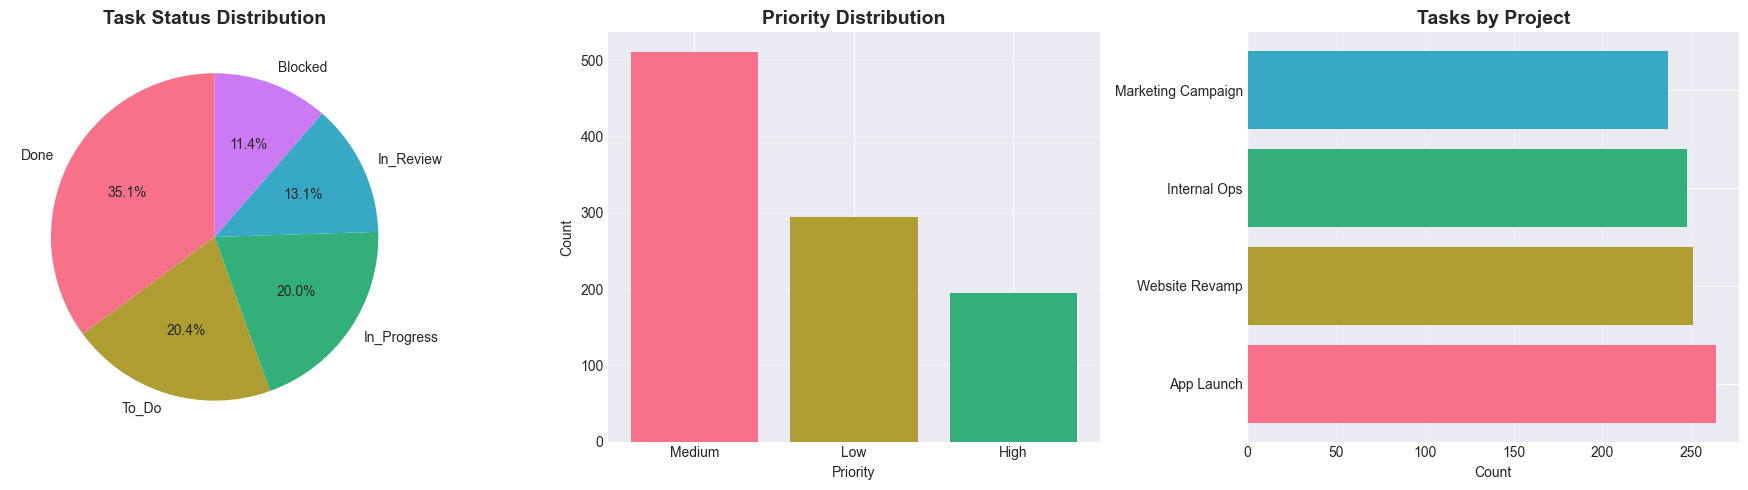


📈 Key Insights:
- Most common status: Done (351 tasks)
- Most common priority: Medium (511 tasks)
- Largest project: App Launch (264 tasks)


In [6]:
# Status distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Status distribution pie chart
status_counts = df['status'].value_counts()
colors = sns.color_palette('husl', len(status_counts))
axes[0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[0].set_title('Task Status Distribution', fontsize=14, fontweight='bold')

# Priority distribution
priority_counts = df['priority'].value_counts()
axes[1].bar(priority_counts.index, priority_counts.values, color=colors[:len(priority_counts)])
axes[1].set_title('Priority Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Priority')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

# Project distribution
project_counts = df['project'].value_counts()
axes[2].barh(project_counts.index, project_counts.values, color=colors[:len(project_counts)])
axes[2].set_title('Tasks by Project', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Count')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Key Insights:")
print(f"- Most common status: {status_counts.index[0]} ({status_counts.values[0]} tasks)")
print(f"- Most common priority: {priority_counts.index[0]} ({priority_counts.values[0]} tasks)")
print(f"- Largest project: {project_counts.index[0]} ({project_counts.values[0]} tasks)")

## 3. Duration & Delay Patterns

📊 Duration Statistics (n=953):

Actual Duration (days):
count    953.000000
mean       6.722980
std        2.932516
min        1.000000
25%        5.000000
50%        6.000000
75%        9.000000
max       18.000000
Name: actual_duration, dtype: float64


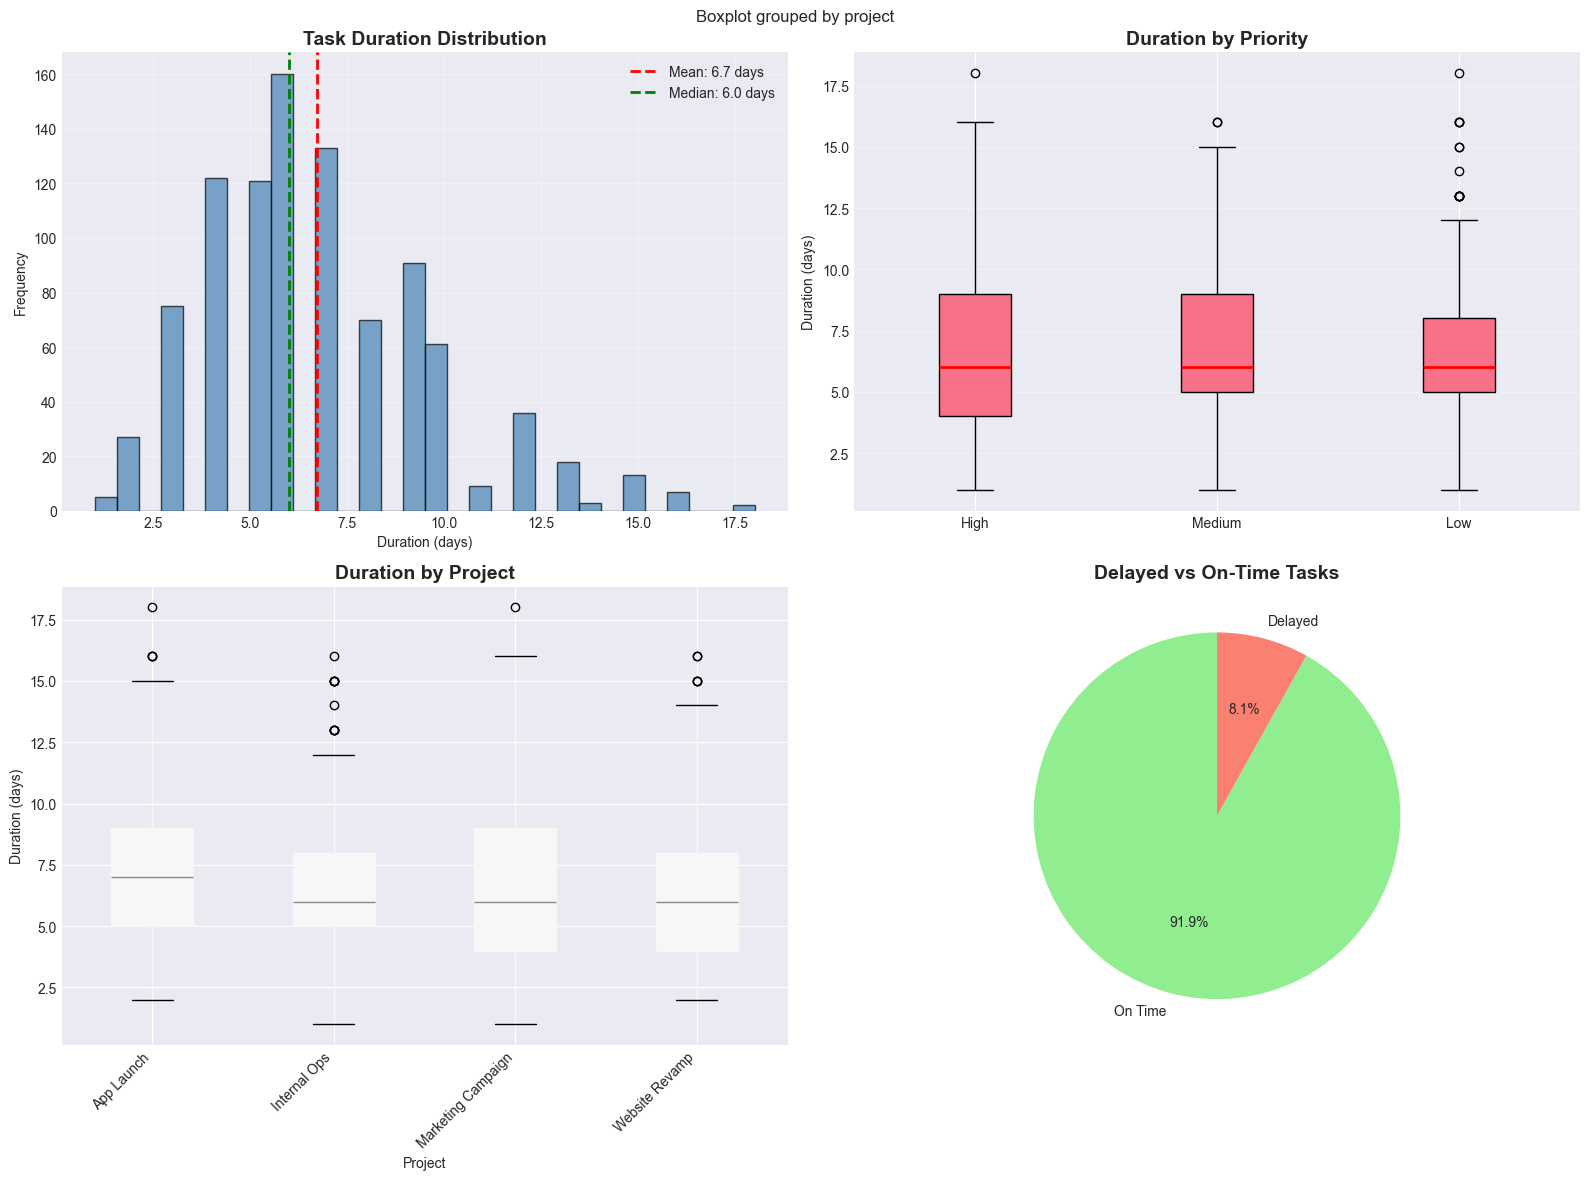

In [7]:
# Duration analysis
completed_tasks = df[df['actual_duration'].notna()].copy()

print(f"📊 Duration Statistics (n={len(completed_tasks)}):")
print(f"\nActual Duration (days):")
print(completed_tasks['actual_duration'].describe())

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Duration distribution histogram
axes[0, 0].hist(completed_tasks['actual_duration'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(completed_tasks['actual_duration'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {completed_tasks['actual_duration'].mean():.1f} days")
axes[0, 0].axvline(completed_tasks['actual_duration'].median(), color='green', linestyle='--', 
                   linewidth=2, label=f"Median: {completed_tasks['actual_duration'].median():.1f} days")
axes[0, 0].set_title('Task Duration Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Duration (days)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Duration by priority
priority_order = ['High', 'Medium', 'Low']
duration_by_priority = [completed_tasks[completed_tasks['priority'] == p]['actual_duration'].values 
                        for p in priority_order if p in completed_tasks['priority'].values]
axes[0, 1].boxplot(duration_by_priority, labels=[p for p in priority_order if p in completed_tasks['priority'].values],
                   patch_artist=True, medianprops=dict(color='red', linewidth=2))
axes[0, 1].set_title('Duration by Priority', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Duration (days)')
axes[0, 1].grid(axis='y', alpha=0.3)

# Duration by project
completed_tasks.boxplot(column='actual_duration', by='project', ax=axes[1, 0], 
                        patch_artist=True, grid=True)
axes[1, 0].set_title('Duration by Project', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Project')
axes[1, 0].set_ylabel('Duration (days)')
plt.sca(axes[1, 0])
plt.xticks(rotation=45, ha='right')

# Delayed vs Non-delayed
delay_counts = df['is_delayed'].value_counts()
axes[1, 1].pie([delay_counts.get(0, 0), delay_counts.get(1, 0)], 
               labels=['On Time', 'Delayed'], 
               autopct='%1.1f%%',
               colors=['lightgreen', 'salmon'],
               startangle=90)
axes[1, 1].set_title('Delayed vs On-Time Tasks', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

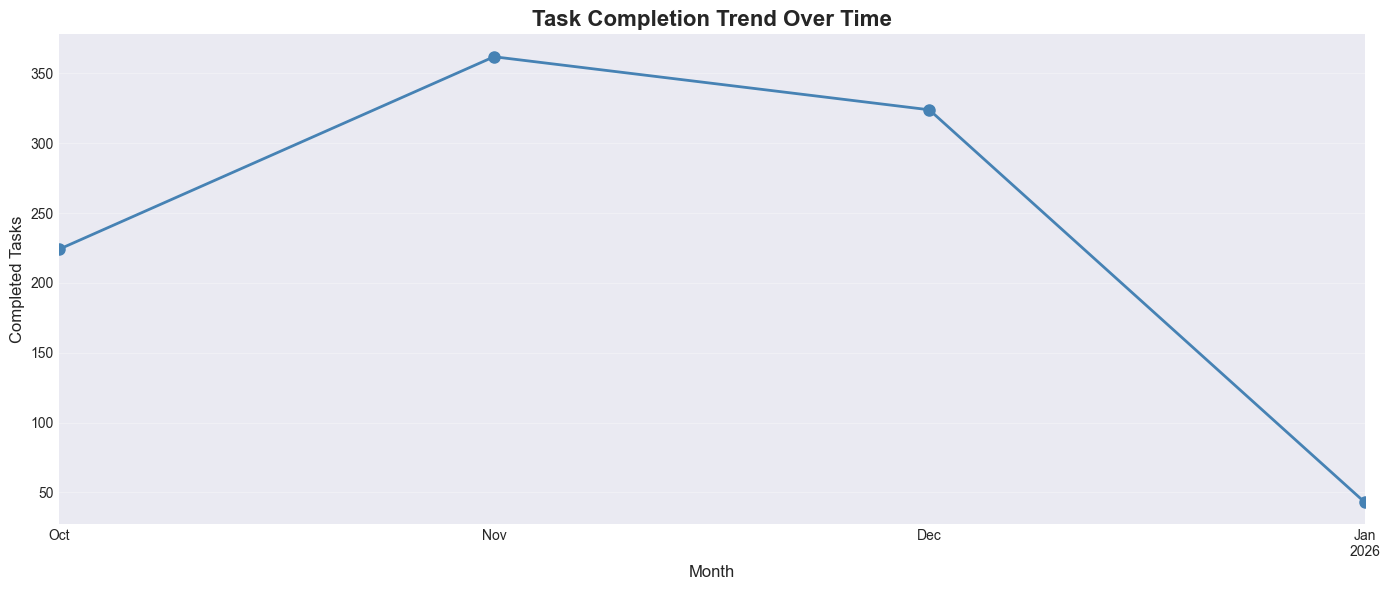


📈 Peak completion month: 2025-11 (362 tasks)
📉 Lowest completion month: 2026-01 (43 tasks)


In [8]:
# Time series of task completion
completed_tasks_time = df[df['end_date'].notna()].copy()
completed_tasks_time['end_month'] = completed_tasks_time['end_date'].dt.to_period('M')
monthly_completion = completed_tasks_time.groupby('end_month').size()

plt.figure(figsize=(14, 6))
monthly_completion.plot(kind='line', marker='o', linewidth=2, markersize=8, color='steelblue')
plt.title('Task Completion Trend Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Completed Tasks', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📈 Peak completion month: {monthly_completion.idxmax()} ({monthly_completion.max()} tasks)")
print(f"📉 Lowest completion month: {monthly_completion.idxmin()} ({monthly_completion.min()} tasks)")

## 4. Assignee Performance Analysis

In [9]:
# Assignee workload analysis
assignee_workload = get_assignee_workload()
print("👥 Assignee Workload & Performance:\n")
print(assignee_workload.sort_values('total_tasks', ascending=False))

👥 Assignee Workload & Performance:

  assignee  total_tasks  active_tasks  avg_duration  delayed_tasks  \
0     Omar          134            94      6.846154             14   
1     Sara          132            90      6.813008             12   
4     John          132            85      6.472868             10   
2      Mei          131            89      6.893443             11   
6     Lina          130            83      6.450820              7   
3   Anjali          120            67      6.745614             11   
5    Ahmed          117            71      6.837838             10   
7   Carlos          104            70      6.745098              6   

   delay_percentage  
0             10.45  
1              9.09  
4              7.58  
2              8.40  
6              5.38  
3              9.17  
5              8.55  
7              5.77  


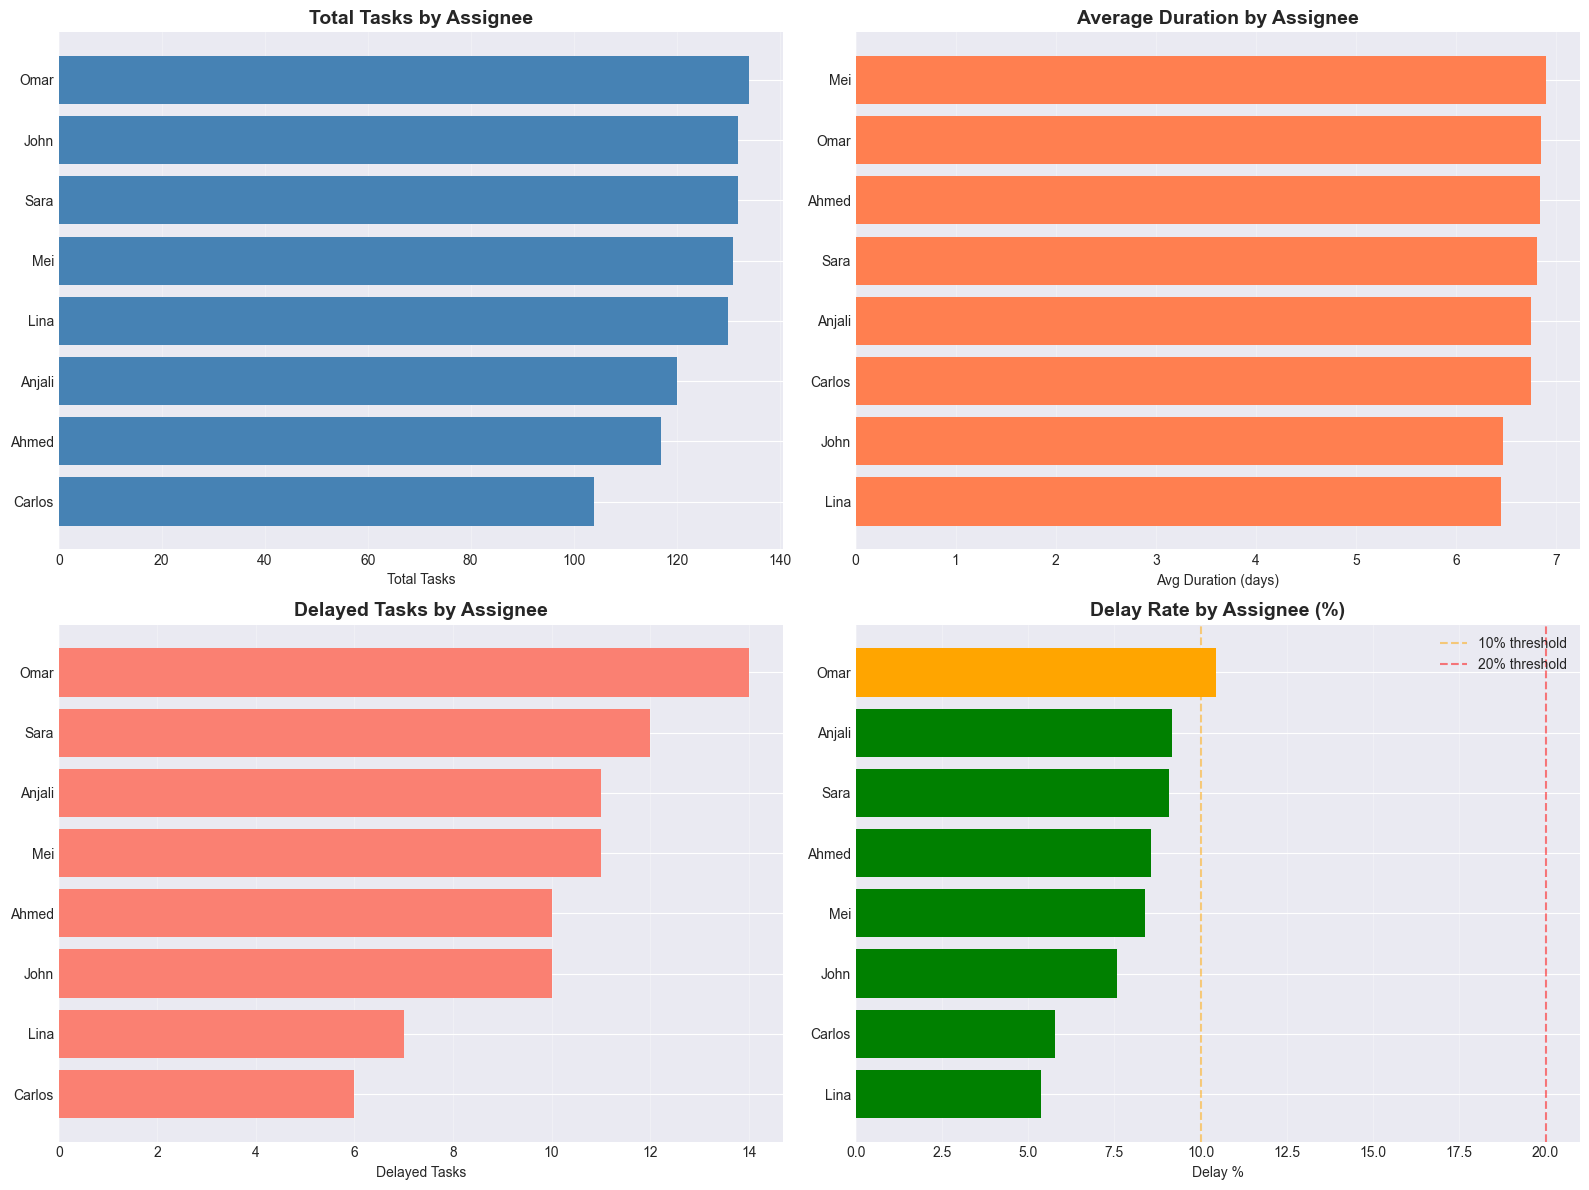


⚠️ High-Risk Assignees (delay rate > 15%):
None found!


In [10]:
# Visualize assignee metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Total tasks by assignee
assignee_workload_sorted = assignee_workload.sort_values('total_tasks', ascending=True)
axes[0, 0].barh(assignee_workload_sorted['assignee'], assignee_workload_sorted['total_tasks'], 
                color='steelblue')
axes[0, 0].set_title('Total Tasks by Assignee', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Total Tasks')
axes[0, 0].grid(axis='x', alpha=0.3)

# Average duration by assignee
assignee_workload_sorted_dur = assignee_workload.sort_values('avg_duration', ascending=True)
axes[0, 1].barh(assignee_workload_sorted_dur['assignee'], assignee_workload_sorted_dur['avg_duration'], 
                color='coral')
axes[0, 1].set_title('Average Duration by Assignee', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Avg Duration (days)')
axes[0, 1].grid(axis='x', alpha=0.3)

# Delayed tasks by assignee
assignee_workload_sorted_del = assignee_workload.sort_values('delayed_tasks', ascending=True)
axes[1, 0].barh(assignee_workload_sorted_del['assignee'], assignee_workload_sorted_del['delayed_tasks'], 
                color='salmon')
axes[1, 0].set_title('Delayed Tasks by Assignee', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Delayed Tasks')
axes[1, 0].grid(axis='x', alpha=0.3)

# Delay percentage
assignee_workload_sorted_pct = assignee_workload.sort_values('delay_percentage', ascending=True)
colors_delay = ['green' if x < 10 else 'orange' if x < 20 else 'red' 
                for x in assignee_workload_sorted_pct['delay_percentage']]
axes[1, 1].barh(assignee_workload_sorted_pct['assignee'], assignee_workload_sorted_pct['delay_percentage'], 
                color=colors_delay)
axes[1, 1].set_title('Delay Rate by Assignee (%)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Delay %')
axes[1, 1].axvline(x=10, color='orange', linestyle='--', alpha=0.5, label='10% threshold')
axes[1, 1].axvline(x=20, color='red', linestyle='--', alpha=0.5, label='20% threshold')
axes[1, 1].legend()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ High-Risk Assignees (delay rate > 15%):")
high_risk = assignee_workload[assignee_workload['delay_percentage'] > 15]
if len(high_risk) > 0:
    print(high_risk[['assignee', 'delayed_tasks', 'delay_percentage']])
else:
    print("None found!")

## 5. Project-Level Insights

In [11]:
# Project metrics
project_metrics = get_project_metrics()
print("🗂️ Project Performance Metrics:\n")
print(project_metrics)

🗂️ Project Performance Metrics:

              project  total_tasks  completed  blocked  avg_duration  \
0          App Launch          264         93       21      7.154150   
1      Website Revamp          251        102       32      6.595833   
2        Internal Ops          248         83       23      6.567100   
3  Marketing Campaign          237         73       38      6.537118   

   delayed_tasks  
0             27  
1             17  
2             15  
3             22  


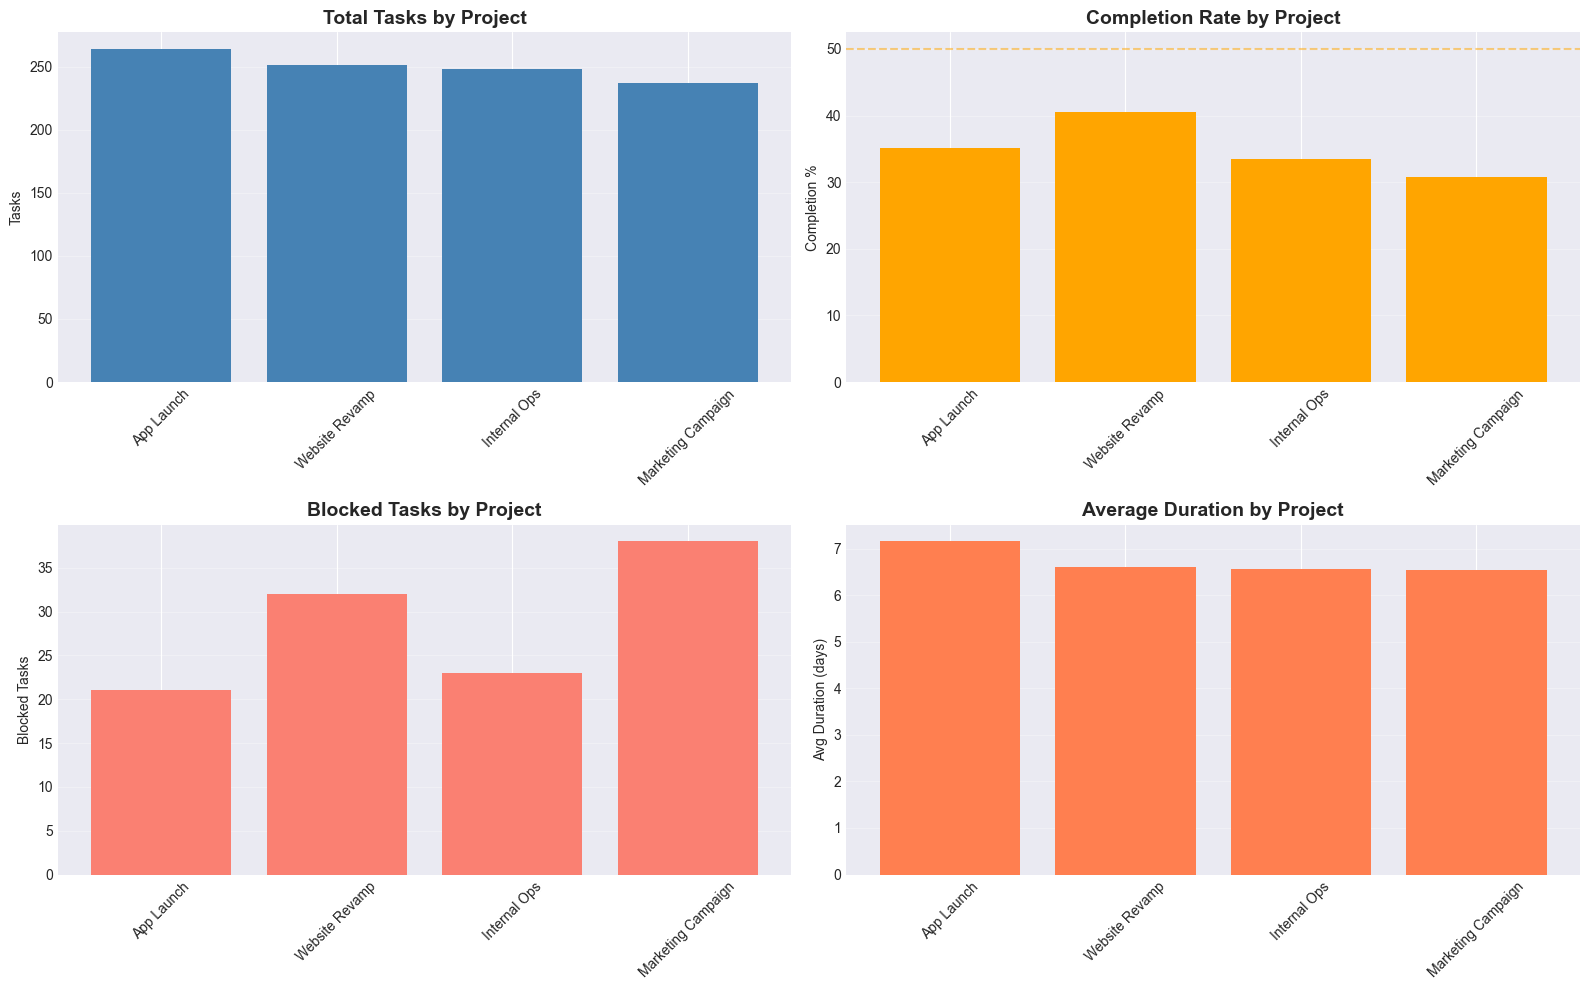

In [12]:
# Project visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Project size
axes[0, 0].bar(project_metrics['project'], project_metrics['total_tasks'], color='steelblue')
axes[0, 0].set_title('Total Tasks by Project', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Tasks')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Completion rate
project_metrics['completion_rate'] = (project_metrics['completed'] / project_metrics['total_tasks'] * 100).round(1)
colors_comp = ['green' if x > 50 else 'orange' if x > 30 else 'red' for x in project_metrics['completion_rate']]
axes[0, 1].bar(project_metrics['project'], project_metrics['completion_rate'], color=colors_comp)
axes[0, 1].set_title('Completion Rate by Project', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Completion %')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].axhline(y=50, color='orange', linestyle='--', alpha=0.5)
axes[0, 1].grid(axis='y', alpha=0.3)

# Blocked tasks
axes[1, 0].bar(project_metrics['project'], project_metrics['blocked'], color='salmon')
axes[1, 0].set_title('Blocked Tasks by Project', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Blocked Tasks')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Average duration
axes[1, 1].bar(project_metrics['project'], project_metrics['avg_duration'], color='coral')
axes[1, 1].set_title('Average Duration by Project', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Avg Duration (days)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Bottleneck Deep Dive

In [13]:
# Bottleneck analysis
bottleneck_summary = get_tasks_by_bottleneck()
print("🚨 Bottleneck Summary:\n")
print(bottleneck_summary)

🚨 Bottleneck Summary:

         bottleneck_type  count  avg_duration  \
0  Resource_Availability    159      6.113208   
1                Blocked    114      6.642857   
2    Assignee_Bottleneck     64     13.156250   
3                Stalled     24           NaN   
4      Review_Bottleneck      8     14.250000   

                            affected_assignees  
0  Carlos,Lina,Omar,Ahmed,Anjali,John,Mei,Sara  
1  Carlos,Lina,John,Mei,Sara,Ahmed,Omar,Anjali  
2  Sara,Omar,John,Anjali,Mei,Carlos,Ahmed,Lina  
3         Sara,Omar,John,Mei,Ahmed,Lina,Anjali  
4                     Mei,Ahmed,Sara,Omar,Lina  


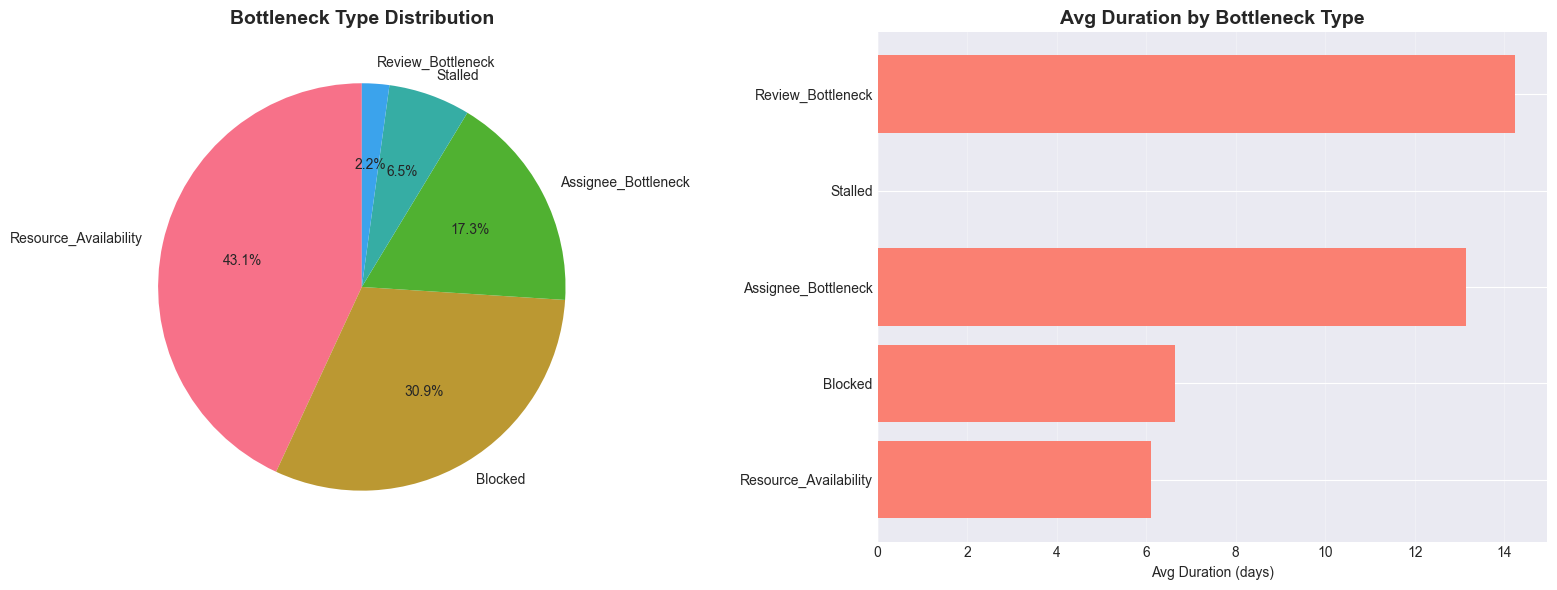

In [14]:
# Visualize bottlenecks
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bottleneck distribution
if len(bottleneck_summary) > 0:
    axes[0].pie(bottleneck_summary['count'], labels=bottleneck_summary['bottleneck_type'], 
                autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Bottleneck Type Distribution', fontsize=14, fontweight='bold')
    
    # Average duration by bottleneck type
    axes[1].barh(bottleneck_summary['bottleneck_type'], bottleneck_summary['avg_duration'], 
                 color='salmon')
    axes[1].set_title('Avg Duration by Bottleneck Type', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Avg Duration (days)')
    axes[1].grid(axis='x', alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'No bottlenecks detected', ha='center', va='center', fontsize=14)
    axes[1].text(0.5, 0.5, 'No bottlenecks detected', ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.show()

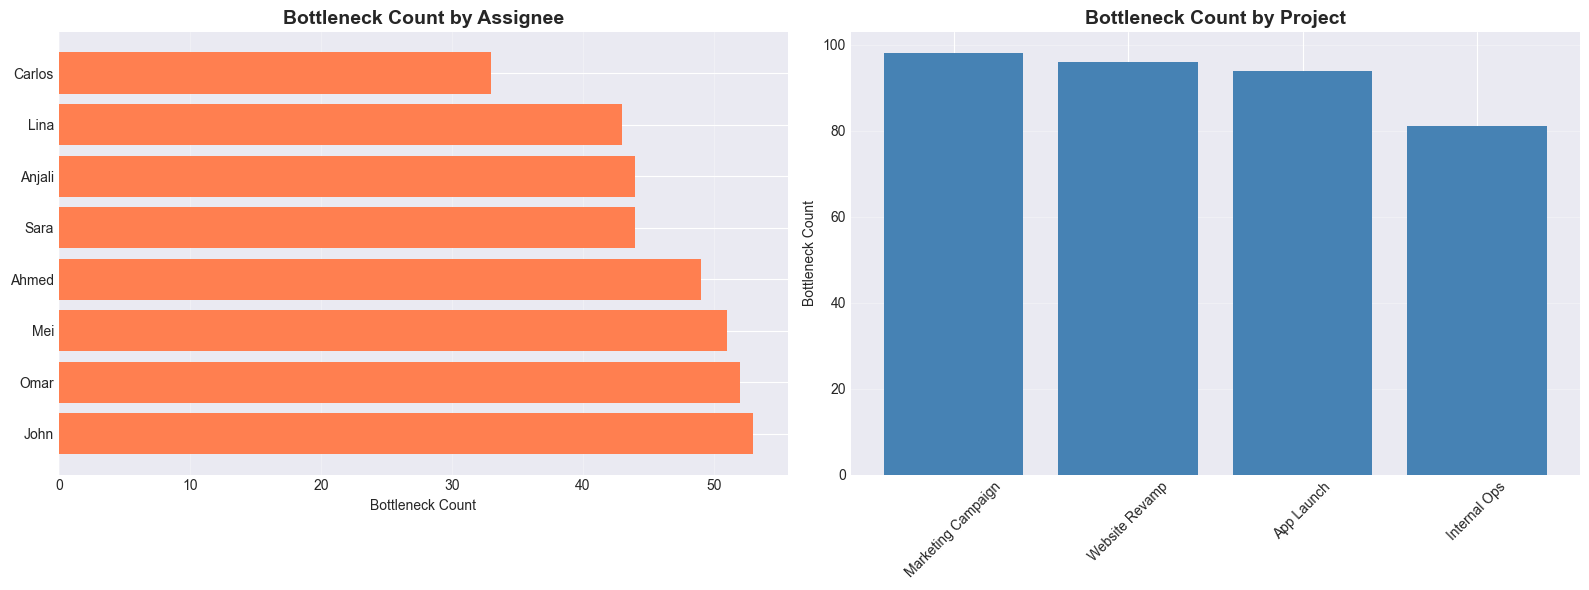


⚠️ Total tasks with bottlenecks: 369 (36.9%)


In [15]:
# Detailed bottleneck analysis by assignee and project
bottleneck_tasks = df[df['bottleneck_type'].notna()].copy()

if len(bottleneck_tasks) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bottlenecks by assignee
    bottleneck_by_assignee = bottleneck_tasks['assignee'].value_counts()
    axes[0].barh(bottleneck_by_assignee.index, bottleneck_by_assignee.values, color='coral')
    axes[0].set_title('Bottleneck Count by Assignee', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Bottleneck Count')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Bottlenecks by project
    bottleneck_by_project = bottleneck_tasks['project'].value_counts()
    axes[1].bar(bottleneck_by_project.index, bottleneck_by_project.values, color='steelblue')
    axes[1].set_title('Bottleneck Count by Project', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Bottleneck Count')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n⚠️ Total tasks with bottlenecks: {len(bottleneck_tasks)} ({len(bottleneck_tasks)/len(df)*100:.1f}%)")
else:
    print("No bottleneck tasks found")

## 7. Key Findings & Recommendations

In [16]:
# Generate comprehensive summary report
print("="*80)
print("📊 FLOWFIX AI - KEY FINDINGS & RECOMMENDATIONS")
print("="*80)

# Overall metrics
print("\n1️⃣ OVERALL WORKFLOW HEALTH:")
total_tasks = len(df)
completed = len(df[df['status'] == 'Done'])
completion_rate = (completed / total_tasks * 100)
delayed_count = df['is_delayed'].sum()
delay_rate = (delayed_count / total_tasks * 100)

print(f"   • Total Tasks: {total_tasks:,}")
print(f"   • Completion Rate: {completion_rate:.1f}%")
print(f"   • Delay Rate: {delay_rate:.1f}%")
print(f"   • Average Duration: {df['actual_duration'].mean():.1f} days")

# Assignee insights
print("\n2️⃣ ASSIGNEE PERFORMANCE:")
top_performer = assignee_workload.loc[assignee_workload['delay_percentage'].idxmin()]
at_risk = assignee_workload.loc[assignee_workload['delay_percentage'].idxmax()]
print(f"   • Top Performer: {top_performer['assignee']} (Delay rate: {top_performer['delay_percentage']:.1f}%)")
print(f"   • Needs Support: {at_risk['assignee']} (Delay rate: {at_risk['delay_percentage']:.1f}%)")
print(f"   • Workload Balance: {assignee_workload['total_tasks'].std():.1f} std dev across team")

# Project insights
print("\n3️⃣ PROJECT PRIORITIES:")
worst_project = project_metrics.loc[project_metrics['blocked'].idxmax()]
print(f"   • Most Blocked: {worst_project['project']} ({worst_project['blocked']} blocked tasks)")
slowest_project = project_metrics.loc[project_metrics['avg_duration'].idxmax()]
print(f"   • Slowest Progress: {slowest_project['project']} ({slowest_project['avg_duration']:.1f} days avg)")

# Bottleneck insights
if len(bottleneck_summary) > 0:
    print("\n4️⃣ CRITICAL BOTTLENECKS:")
    top_bottleneck = bottleneck_summary.iloc[0]
    print(f"   • Primary Issue: {top_bottleneck['bottleneck_type']} ({top_bottleneck['count']} occurrences)")
    print(f"   • Impact: {len(bottleneck_tasks)/total_tasks*100:.1f}% of tasks affected")

# Recommendations
print("\n5️⃣ ACTIONABLE RECOMMENDATIONS:")
print("   ✅ Redistribute workload from overloaded assignees")
print("   ✅ Address blocked tasks in high-priority projects")
print("   ✅ Implement review process improvements")
print("   ✅ Set up automated alerts for tasks exceeding thresholds")
print("   ✅ Schedule 1-on-1s with assignees having >15% delay rate")

print("\n" + "="*80)
print("✅ EDA Complete - Ready for ML Modeling")
print("="*80)

📊 FLOWFIX AI - KEY FINDINGS & RECOMMENDATIONS

1️⃣ OVERALL WORKFLOW HEALTH:
   • Total Tasks: 1,000
   • Completion Rate: 35.1%
   • Delay Rate: 8.1%
   • Average Duration: 6.7 days

2️⃣ ASSIGNEE PERFORMANCE:
   • Top Performer: Lina (Delay rate: 5.4%)
   • Needs Support: Omar (Delay rate: 10.4%)
   • Workload Balance: 10.5 std dev across team

3️⃣ PROJECT PRIORITIES:
   • Most Blocked: Marketing Campaign (38 blocked tasks)
   • Slowest Progress: App Launch (7.2 days avg)

4️⃣ CRITICAL BOTTLENECKS:
   • Primary Issue: Resource_Availability (159 occurrences)
   • Impact: 36.9% of tasks affected

5️⃣ ACTIONABLE RECOMMENDATIONS:
   ✅ Redistribute workload from overloaded assignees
   ✅ Address blocked tasks in high-priority projects
   ✅ Implement review process improvements
   ✅ Set up automated alerts for tasks exceeding thresholds
   ✅ Schedule 1-on-1s with assignees having >15% delay rate

✅ EDA Complete - Ready for ML Modeling


In [17]:
# Export key findings to CSV for reporting
summary_report = pd.DataFrame({
    'Metric': [
        'Total Tasks',
        'Completion Rate (%)',
        'Delay Rate (%)',
        'Avg Duration (days)',
        'Bottlenecked Tasks',
        'High-Risk Assignees'
    ],
    'Value': [
        total_tasks,
        f"{completion_rate:.1f}",
        f"{delay_rate:.1f}",
        f"{df['actual_duration'].mean():.1f}",
        len(bottleneck_tasks) if len(bottleneck_tasks) > 0 else 0,
        len(assignee_workload[assignee_workload['delay_percentage'] > 15])
    ]
})

export_path = os.path.join(os.path.dirname(os.getcwd()), 'exports', 'eda_summary.csv')
os.makedirs(os.path.dirname(export_path), exist_ok=True)
summary_report.to_csv(export_path, index=False)
print(f"\n📄 Summary exported to: {export_path}")


📄 Summary exported to: c:\Users\anshu\Desktop\Projects\Avish_flow\exports\eda_summary.csv
